# Bode plots

#### A quick introduction to how one can make bode plots in python

This is the first notebook in a series providing examples and code to test concepts. Still a work in progress, if there is anything missing or you have some general feedback please contact Sjur Føyen at foyen.sjur@ntnu.no 

(uses control package; install in terminal with: pip install control)


Code implemented by; Varg Førland. Date; 29.01.2025

Last update; 29.01.2025

GitHub Copilot used for assistance in coding.

In [2]:
# INCLUDES; RUN FIRST!!! (this notebook uses the control package. Documentation found in the link below, remember to pip install control in the terminal)

import control
import matplotlib.pyplot as plt
import numpy as np

# Control package documentation
"""https://python-control.readthedocs.io/en/0.10.0/"""

# Example used for control package:
"""https://jckantor.github.io/CBE30338/05.03-Creating-Bode-Plots.html"""
# requires coefficients of the numerator and denominator polynomials
# the coefficients are given starting with the highest power of


'https://jckantor.github.io/CBE30338/05.03-Creating-Bode-Plots.html'

### Bode plot basics

Bode plots are used to assess stability by... (fill in some theory)

### Example 1 - Comparison of P, PI and PID controller in 3rd order linearized model with controllers
(see Machowski chap. 11)



<TransferFunction>: Generator
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


  0.06667
-----------
1.333 s + 1

<TransferFunction>: $P_{closed-loop}$(s)
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


              0.06044 s^3 + 0.952 s^2 + 3.702 s + 2.267
---------------------------------------------------------------------
0.003556 s^5 + 0.09422 s^4 + 0.8464 s^3 + 3.197 s^2 + 6.316 s + 3.267



/Users/varg/TOPSDUMMY/TOPS/.venv/lib/python3.12/site-packages/control/freqplot.py:338: UserWarning: `omega` ignored when passed response data
  warnings.warn("`omega` ignored when passed response data")


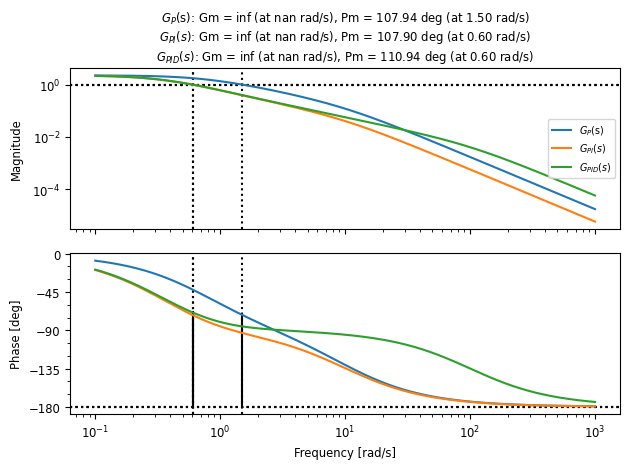

/Users/varg/TOPSDUMMY/TOPS/.venv/lib/python3.12/site-packages/control/freqplot.py:338: UserWarning: `omega` ignored when passed response data
  warnings.warn("`omega` ignored when passed response data")


<TransferFunction>: $P_{closed-loop}$(s)
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


              0.06044 s^3 + 0.952 s^2 + 3.702 s + 2.267
---------------------------------------------------------------------
0.003556 s^5 + 0.09422 s^4 + 0.8464 s^3 + 3.197 s^2 + 6.316 s + 3.267

<TransferFunction>: $PI_{closed-loop}$(s)
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


            0.1813 s^5 + 3.098 s^4 + 14.98 s^3 + 22.56 s^2 + 12.77 s + 2.267
----------------------------------------------------------------------------------------
0.032 s^7 + 0.8693 s^6 + 8.187 s^5 + 32.13 s^4 + 56.77 s^3 + 50.39 s^2 + 21.38 s + 3.267

<TransferFunction>: $PID_{closed-loop}$(s)
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


            0.0001813 s^7 + 0.02304 s^6 + 0.5371 s^5 + 4.768 s^4 + 17.47 s^3 + 23.97 s^2 + 13.02 s + 2.267
----------------------------------------------------------------------------------------------------------------------
3.2e-06 s^9 + 0.0007269 s^8 + 0.05021 s^7 + 1.037 s^6 + 8.92

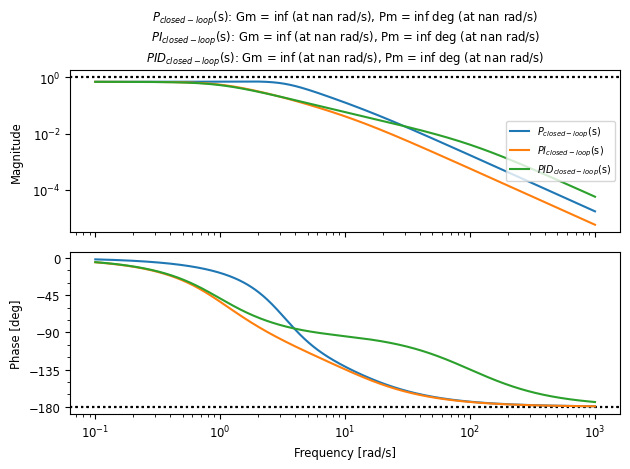

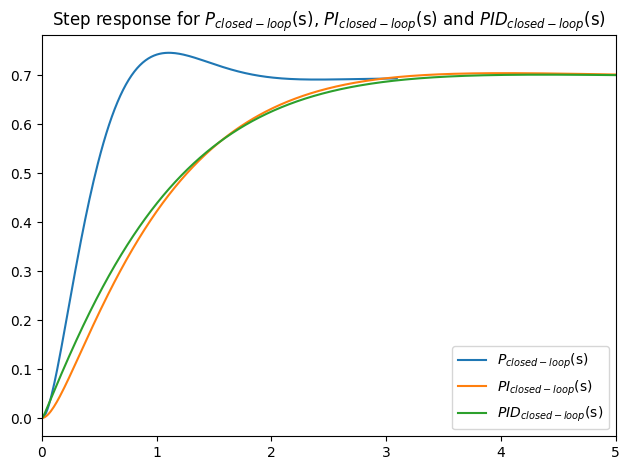

In [3]:

# Total gain for control block G(s)
K_A = 34

# T_A > T_B for limited integral (TGR, phase lag)
T_A = 1
T_B = 3

# T_D < T_A and T_D > T_F for derivative (phase lead)
T_D = 0.1
T_F = .01

# Exciter time constant, assume not tunable, T_e = 0.1 TOPS standard value
# Static rectifier : Te ~ 0.05-0.1 sec. Brush-less: Te ~ 0.2-1 sec. (According to Kjetil Uhlen)
T_E = 0.1

# Generator block:
K_3 = 0.3/1.8 # = xd_t/xd = B
K_6 = 0.4 # Modeling gain from Eq to Vt, in other words, voltage drop from generator to terminal Given values between 0.2-0.4
T_d0_t = 8 

# Feedback Block (set to one period)
T_m = 0.2


ExciterBlock = control.tf([1], [T_E, 1], name = "Exciter")

GainBlock = K_A*control.tf([1],[1])

IntegratorBlock = control.tf([T_A, 1],[T_B, 1])

DerivatorBlock = control.tf([T_D, 1], [T_F, 1])

GeneratorBlock = control.tf([K_3*K_6], [T_d0_t*K_3, 1], name ="Generator")

print(GeneratorBlock)

# Feedback block - measurement
Hs = control.tf(control.tf([1], [T_m, 1], name = "Measur"))

G_P = control.tf(ExciterBlock*GainBlock*GeneratorBlock, name = r"$G_P$(s)")

G_PI = control.tf(ExciterBlock*GainBlock*IntegratorBlock*GeneratorBlock, name = r"$G_{PI}(s)$")

G_PID = control.tf(ExciterBlock*GainBlock*IntegratorBlock*DerivatorBlock*GeneratorBlock, name = r"$G_{PID}(s)$")


Closed_loop_P = control.tf(G_P/(1+G_P*Hs), name = r"$P_{closed-loop}$(s)")
Closed_loop_PI = control.tf(G_PI/(1+G_PI*Hs), name = r"$PI_{closed-loop}$(s)")
Closed_loop_PID = control.tf(G_PID/(1+G_PID*Hs), name = r"$PID_{closed-loop}$(s)")

print(Closed_loop_P)

# Frequency range
w = np.logspace(-3,3,200)
response = control.frequency_response([G_P, G_PI, G_PID])
control.bode_plot(response, initial_phase=0, display_margins=True, omega = w)
plt.show()
response = control.frequency_response([Closed_loop_P, Closed_loop_PI, Closed_loop_PID])
control.bode_plot(response, initial_phase=0, display_margins=True, omega = w)
# plt.show()

responseP = control.step_response(Closed_loop_P)
responsePI = control.step_response(Closed_loop_PI)
responsePID = control.step_response(Closed_loop_PID)

time, outputs, inputs = responseP.time, responseP.outputs, responseP.inputs
time1, outputs1, inputs1 = responsePI.time, responsePI.outputs, responsePI.inputs
time2, outputs2, inputs2 = responsePID.time, responsePID.outputs, responsePID.inputs

plt.figure()
plt.plot(time, outputs, label = "$P_{closed-loop}$(s)")
plt.plot(time1, outputs1, label = "$PI_{closed-loop}$(s)")
plt.plot(time2, outputs2, label = "$PID_{closed-loop}$(s)")
plt.xlim(0,5)
plt.title("Step response for $P_{closed-loop}$(s), $PI_{closed-loop}$(s) and $PID_{closed-loop}$(s)")
plt.tight_layout()
plt.legend()

print(Closed_loop_P)
print(Closed_loop_PI)
print(Closed_loop_PID)


plt.show()


